In [1]:
import numpy as np 
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
# root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
# path.insert(1,  root)
# path.insert(1,  root+'/work')
# # import work.lw_csaf_Li5Relu_EN.train_script01 as lwcsafen
# import lw_csaf_Li5Relu_EY.train_script01 as lwcsafey 
# # import work.lw_af_Li5Relu_EN.train_script01 as lwafen
# import lw_af_Li5Relu_EY.train_script01 as lwafey 

In [3]:
plt.rcParams['font.size'] = '6'

In [4]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE/'
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE_base/'
ds = xr.open_dataset(file_path+'POSTP/20000101.atmos_8xdaily.nc') 
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})

In [5]:
def plot_var12_diff(var1,level = np.arange(0,300,10), dlevel = np.arange(-10,10.1,0.5)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds[var1[i]].mean('time').load()
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    da = (ds[var1[0]].mean('time')-ds[var1[1]].mean('time')).load()
    da.plot(ax=ax, levels=dlevel, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}')  
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

# OLR Clear- and All-sky 

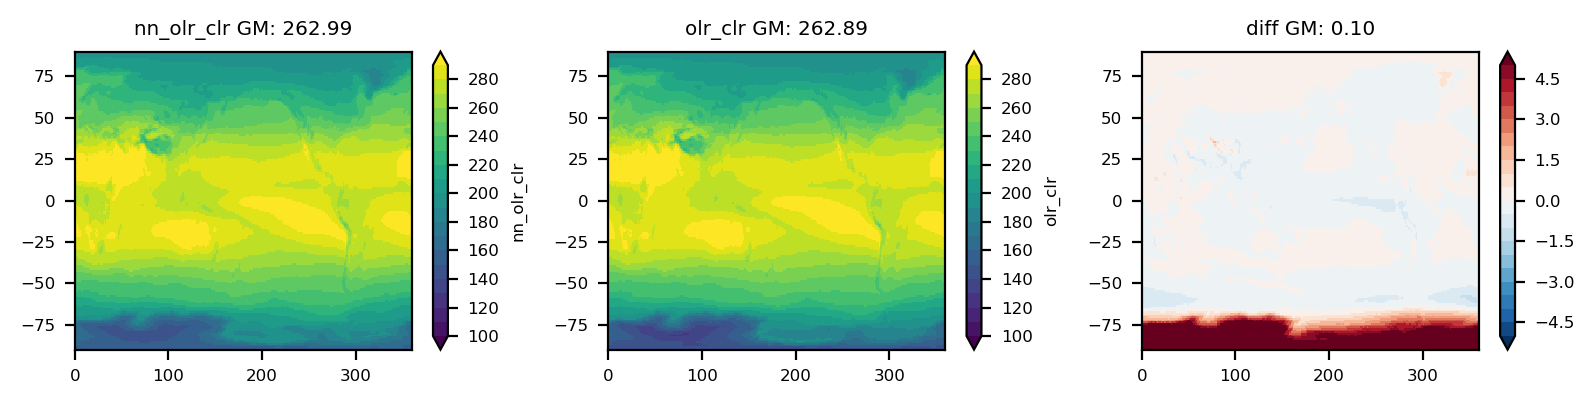

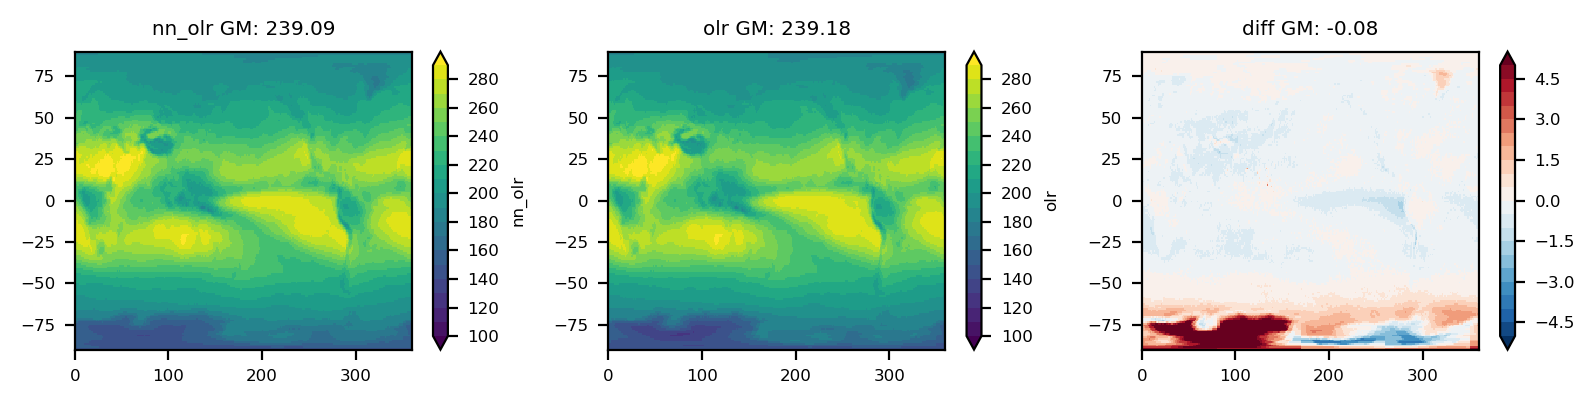

In [6]:
var = ['nn_olr_clr','olr_clr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5.1,0.5))

var = ['nn_olr','olr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5.1,0.5))

# rsut Clear- and All-sky 

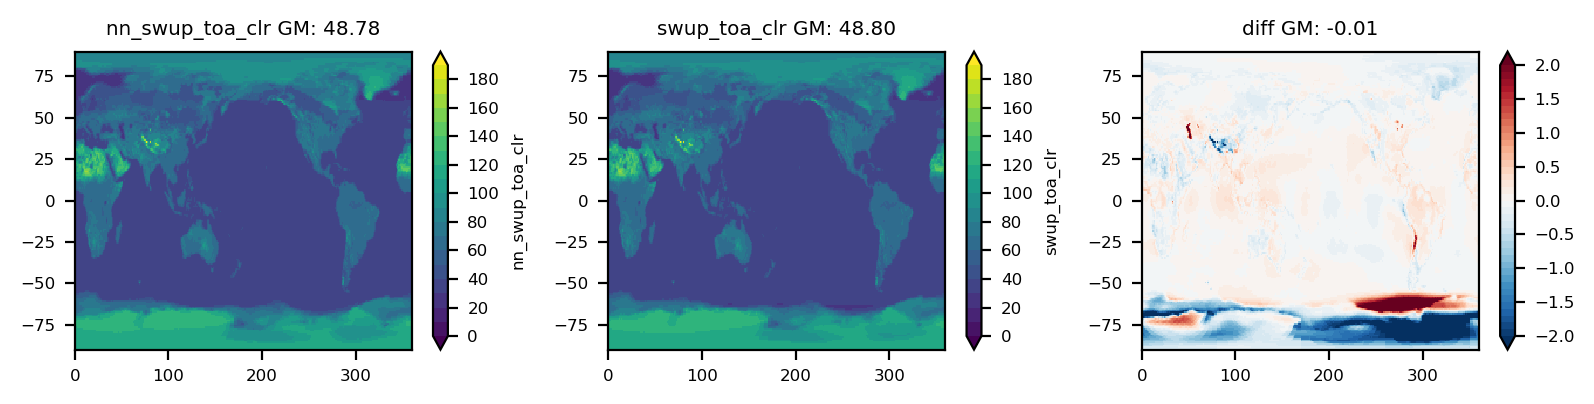

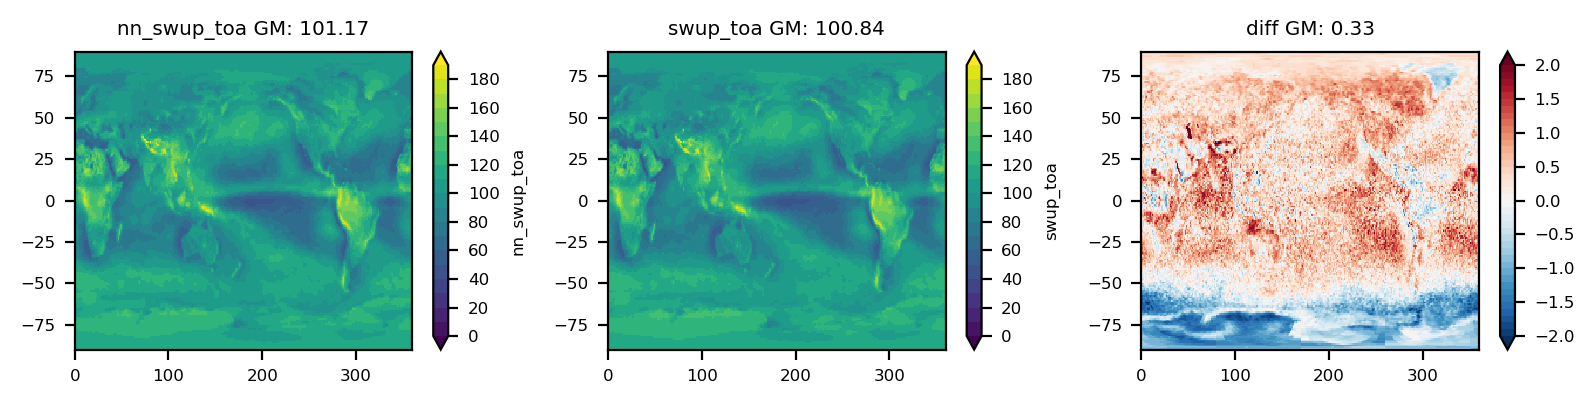

In [7]:
var = ['nn_swup_toa_clr','swup_toa_clr',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))
var = ['nn_swup_toa','swup_toa',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))

# rsds Clear- and All-sky 

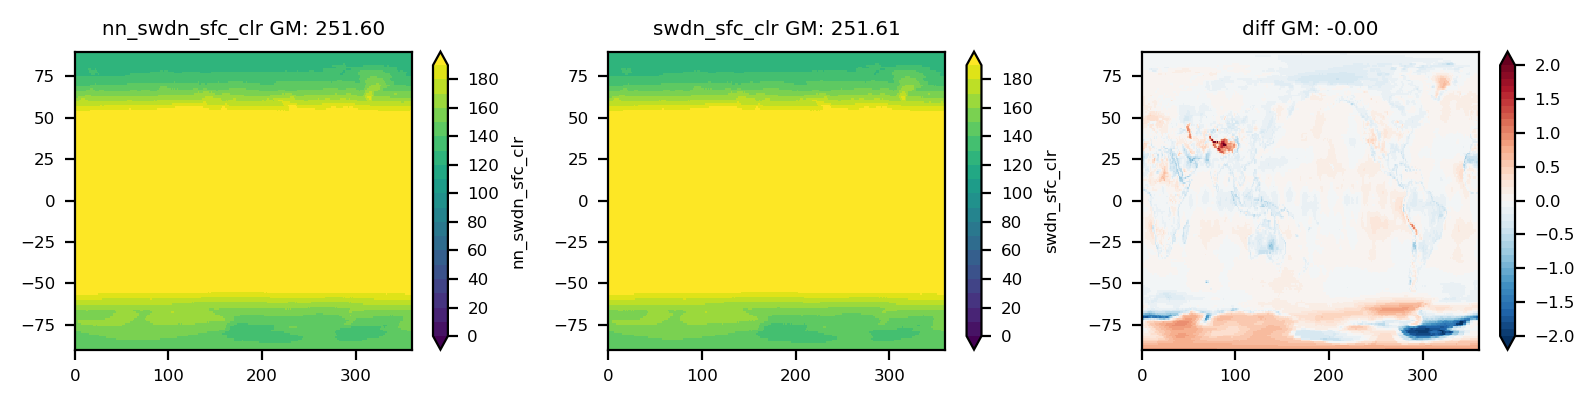

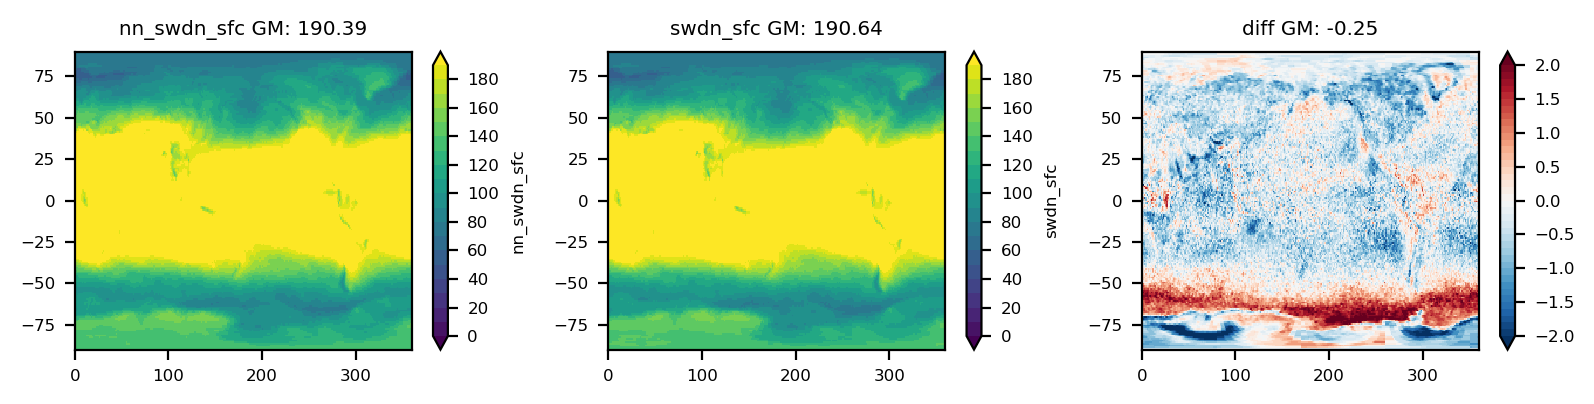

In [8]:
var = ['nn_swdn_sfc_clr','swdn_sfc_clr',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))
var = ['nn_swdn_sfc','swdn_sfc',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))

In [9]:
def plot_var12_diff2(var1,ds_sel,level1=np.arange(-500,1400,100),level2=np.arange(-500,500.1,100)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten() 
    for i in range(3): 
        ax=axs[i] 
        da = ds_sel[var1[0]]
        da.plot.contour(ax=ax, levels=np.arange(-500,1400,500)) 
    for i in range(2):
        ax=axs[i]
        da = ds_sel[var1[i]]
        da.plot(ax=ax, levels=level1, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    level = level2
    da = (ds_sel[var1[1]]-ds_sel[var1[0]])
    da.plot(ax=ax, levels=level2, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

# Diff in rsdt

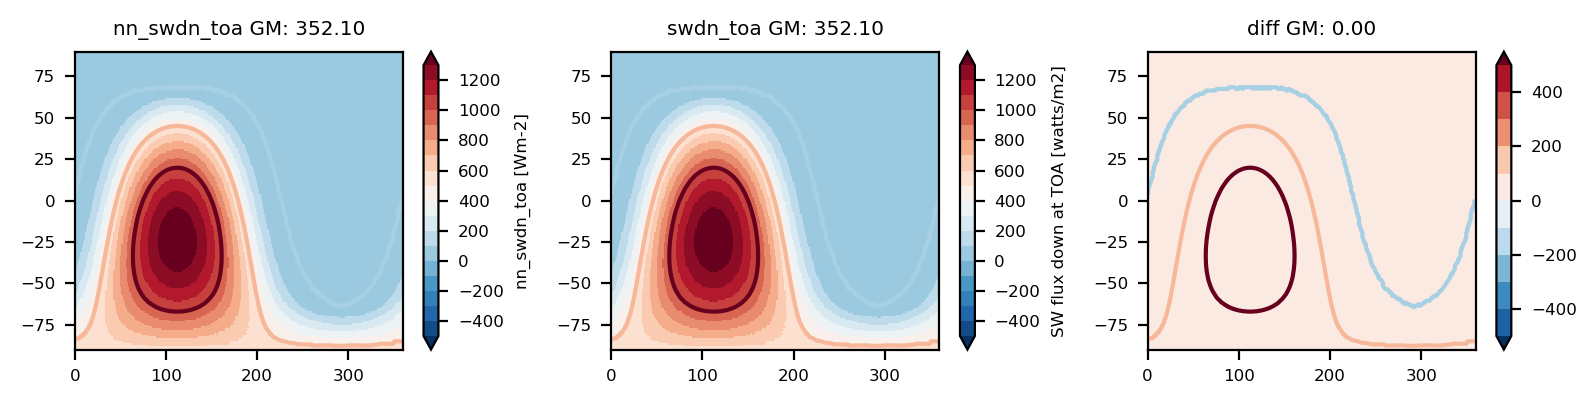

In [10]:
var = ['nn_swdn_toa','swdn_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=0)
plot_var12_diff2(var,ds_sel)

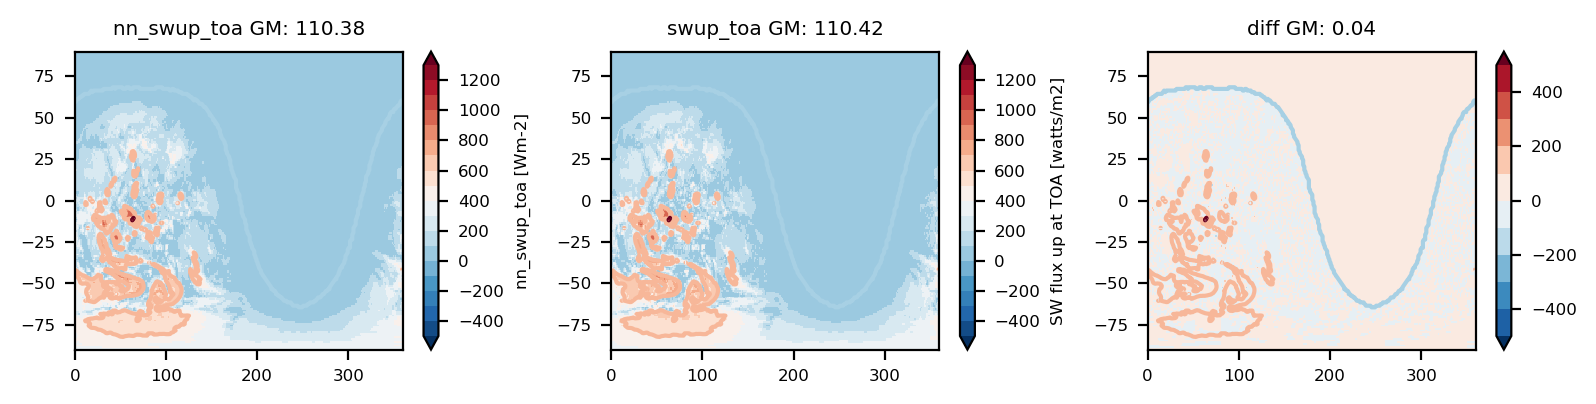

In [11]:
var = ['nn_swup_toa','swup_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=1)
plot_var12_diff2(var,ds_sel)

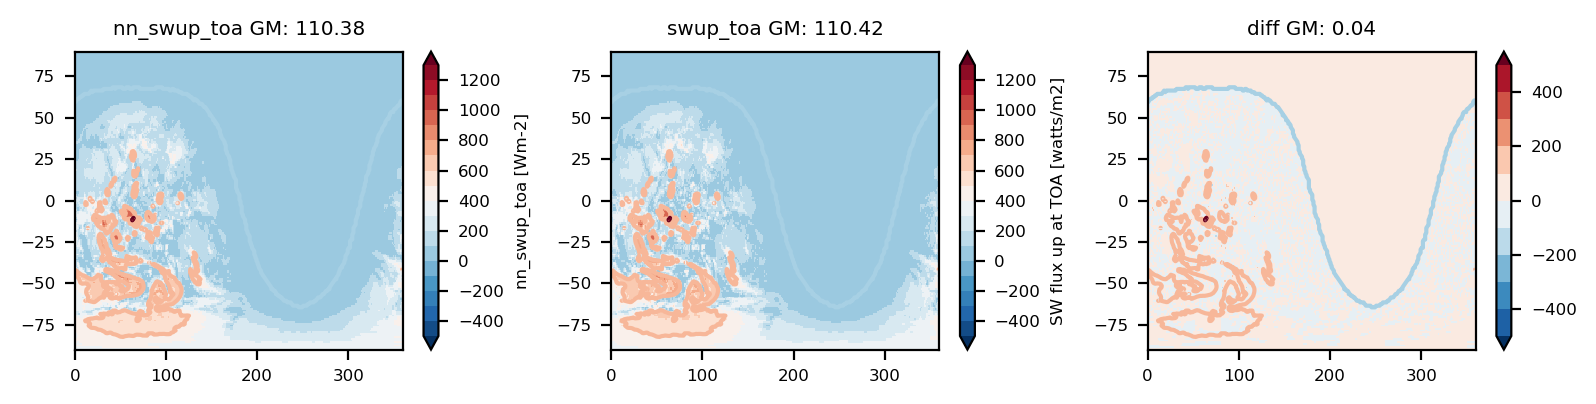

In [12]:
var = ['nn_swup_toa','swup_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=1)
plot_var12_diff2(var,ds_sel)

# Check Error in Energe conservation

## lw

In [13]:

hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values
B_k = hybrid_p_sigma_para.bk.values 
def energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rlus - rlut - rlds 
    sum_Cphr_gdp = C_p/g * (tdt_lw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err
def energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rsdt - rsut + rsus - rsds 
    sum_Cphr_gdp = C_p/g * (tdt_sw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err

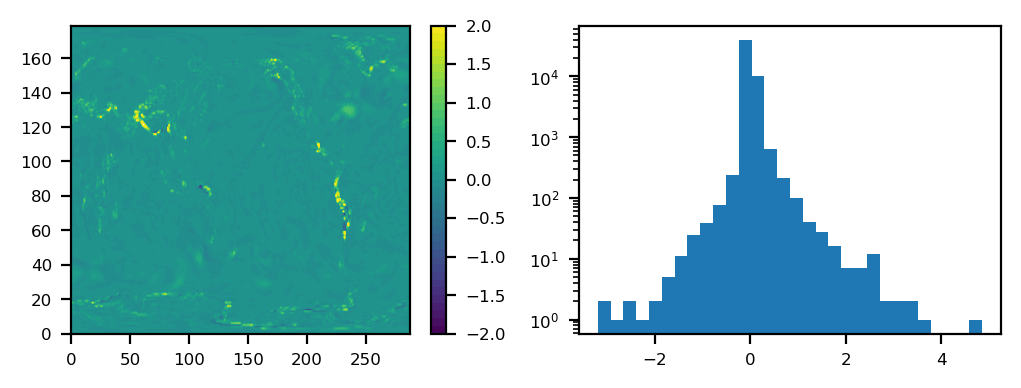

In [14]:
ds_sel = ds.isel(time=[0,1,2,3,4,5,6]).mean('time')
rlut = ds_sel['olr'].values
rlus = ds_sel['lwup_sfc'].values
rlds = ds_sel['lwdn_sfc'].values
tdt_lw = ds_sel['tdt_lw'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

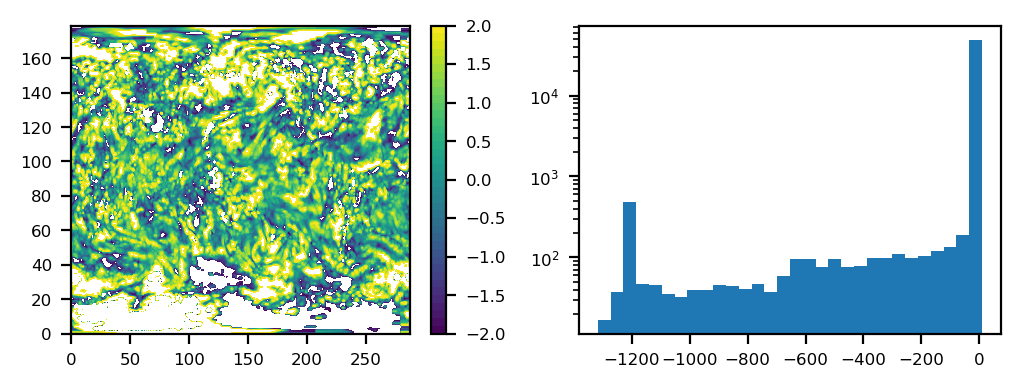

In [15]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rlut = ds_sel['nn_olr_clr'].values
rlus = ds_sel['nn_lwup_sfc'].values
rlds = ds_sel['nn_lwdn_sfc_clr'].values
tdt_lw = ds_sel['nn_tdt_lw_clr'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

##  sw

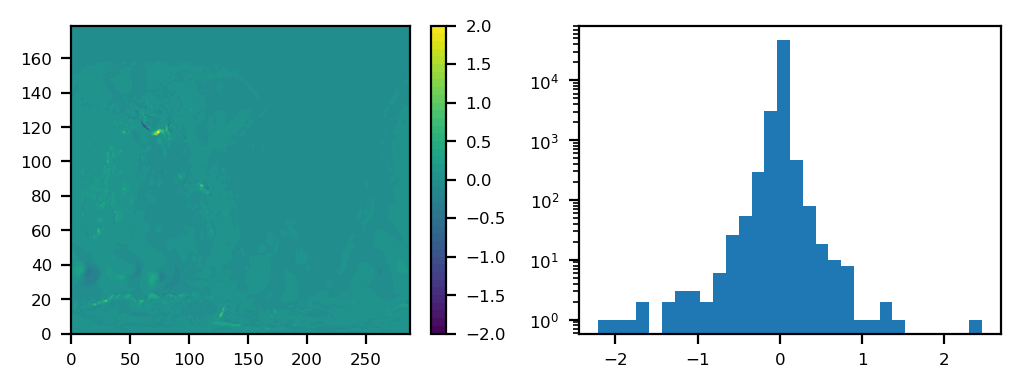

In [18]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['swup_toa'].values
rsdt = ds_sel['swdn_toa'].values
rsus = ds_sel['swup_sfc'].values
rsds = ds_sel['swdn_sfc'].values
tdt_sw = ds_sel['tdt_sw'].values
ps   = ds_sel['ps'].values
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

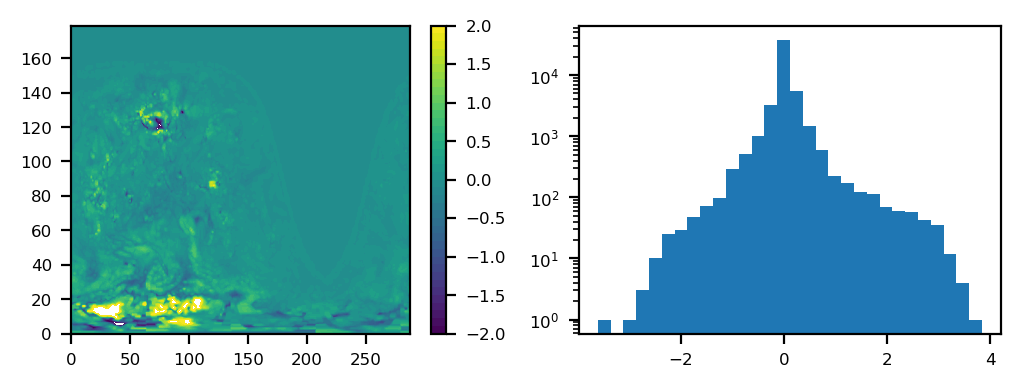

In [19]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['nn_swup_toa'].values
rsdt = ds_sel['nn_swdn_toa'].values
rsus = ds_sel['nn_swup_sfc'].values
rsds = ds_sel['nn_swdn_sfc'].values
tdt_sw = ds_sel['nn_tdt_sw'].values
ps   = ds_sel['ps'].values
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

# nn ratio

In [20]:
 
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds
    data = ds_sel['nn_lwup_sfc'][1200:,:,:].values
    tmp = np.where(data<50, 1, 0 )
    tmp = np.sum(tmp)
    print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

20936 15925248  0.13%
79933 15925248  0.50%
34147 15925248  0.21%
53880 15925248  0.34%
35185 15925248  0.22%
1199510 15925248  7.53%


In [21]:
 
ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds_sel = ds
data = ds_sel['nn_lwup_sfc'][:24,:,:].values
tmp = np.where(data<50, 1, 0 )
tmp = np.sum(tmp)
print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

32445 1244160  2.61%


In [22]:
 
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds
    data = ds_sel['nn_lwup_sfc'][:24,:,:].values
    tmp = np.where(data<-100, 1, 0 )
    tmp = np.sum(tmp)
    print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

191 221184  0.09%
443 221184  0.20%
813 221184  0.37%
478 221184  0.22%
419 221184  0.19%
4421 221184  2.00%


# Compare with offline results

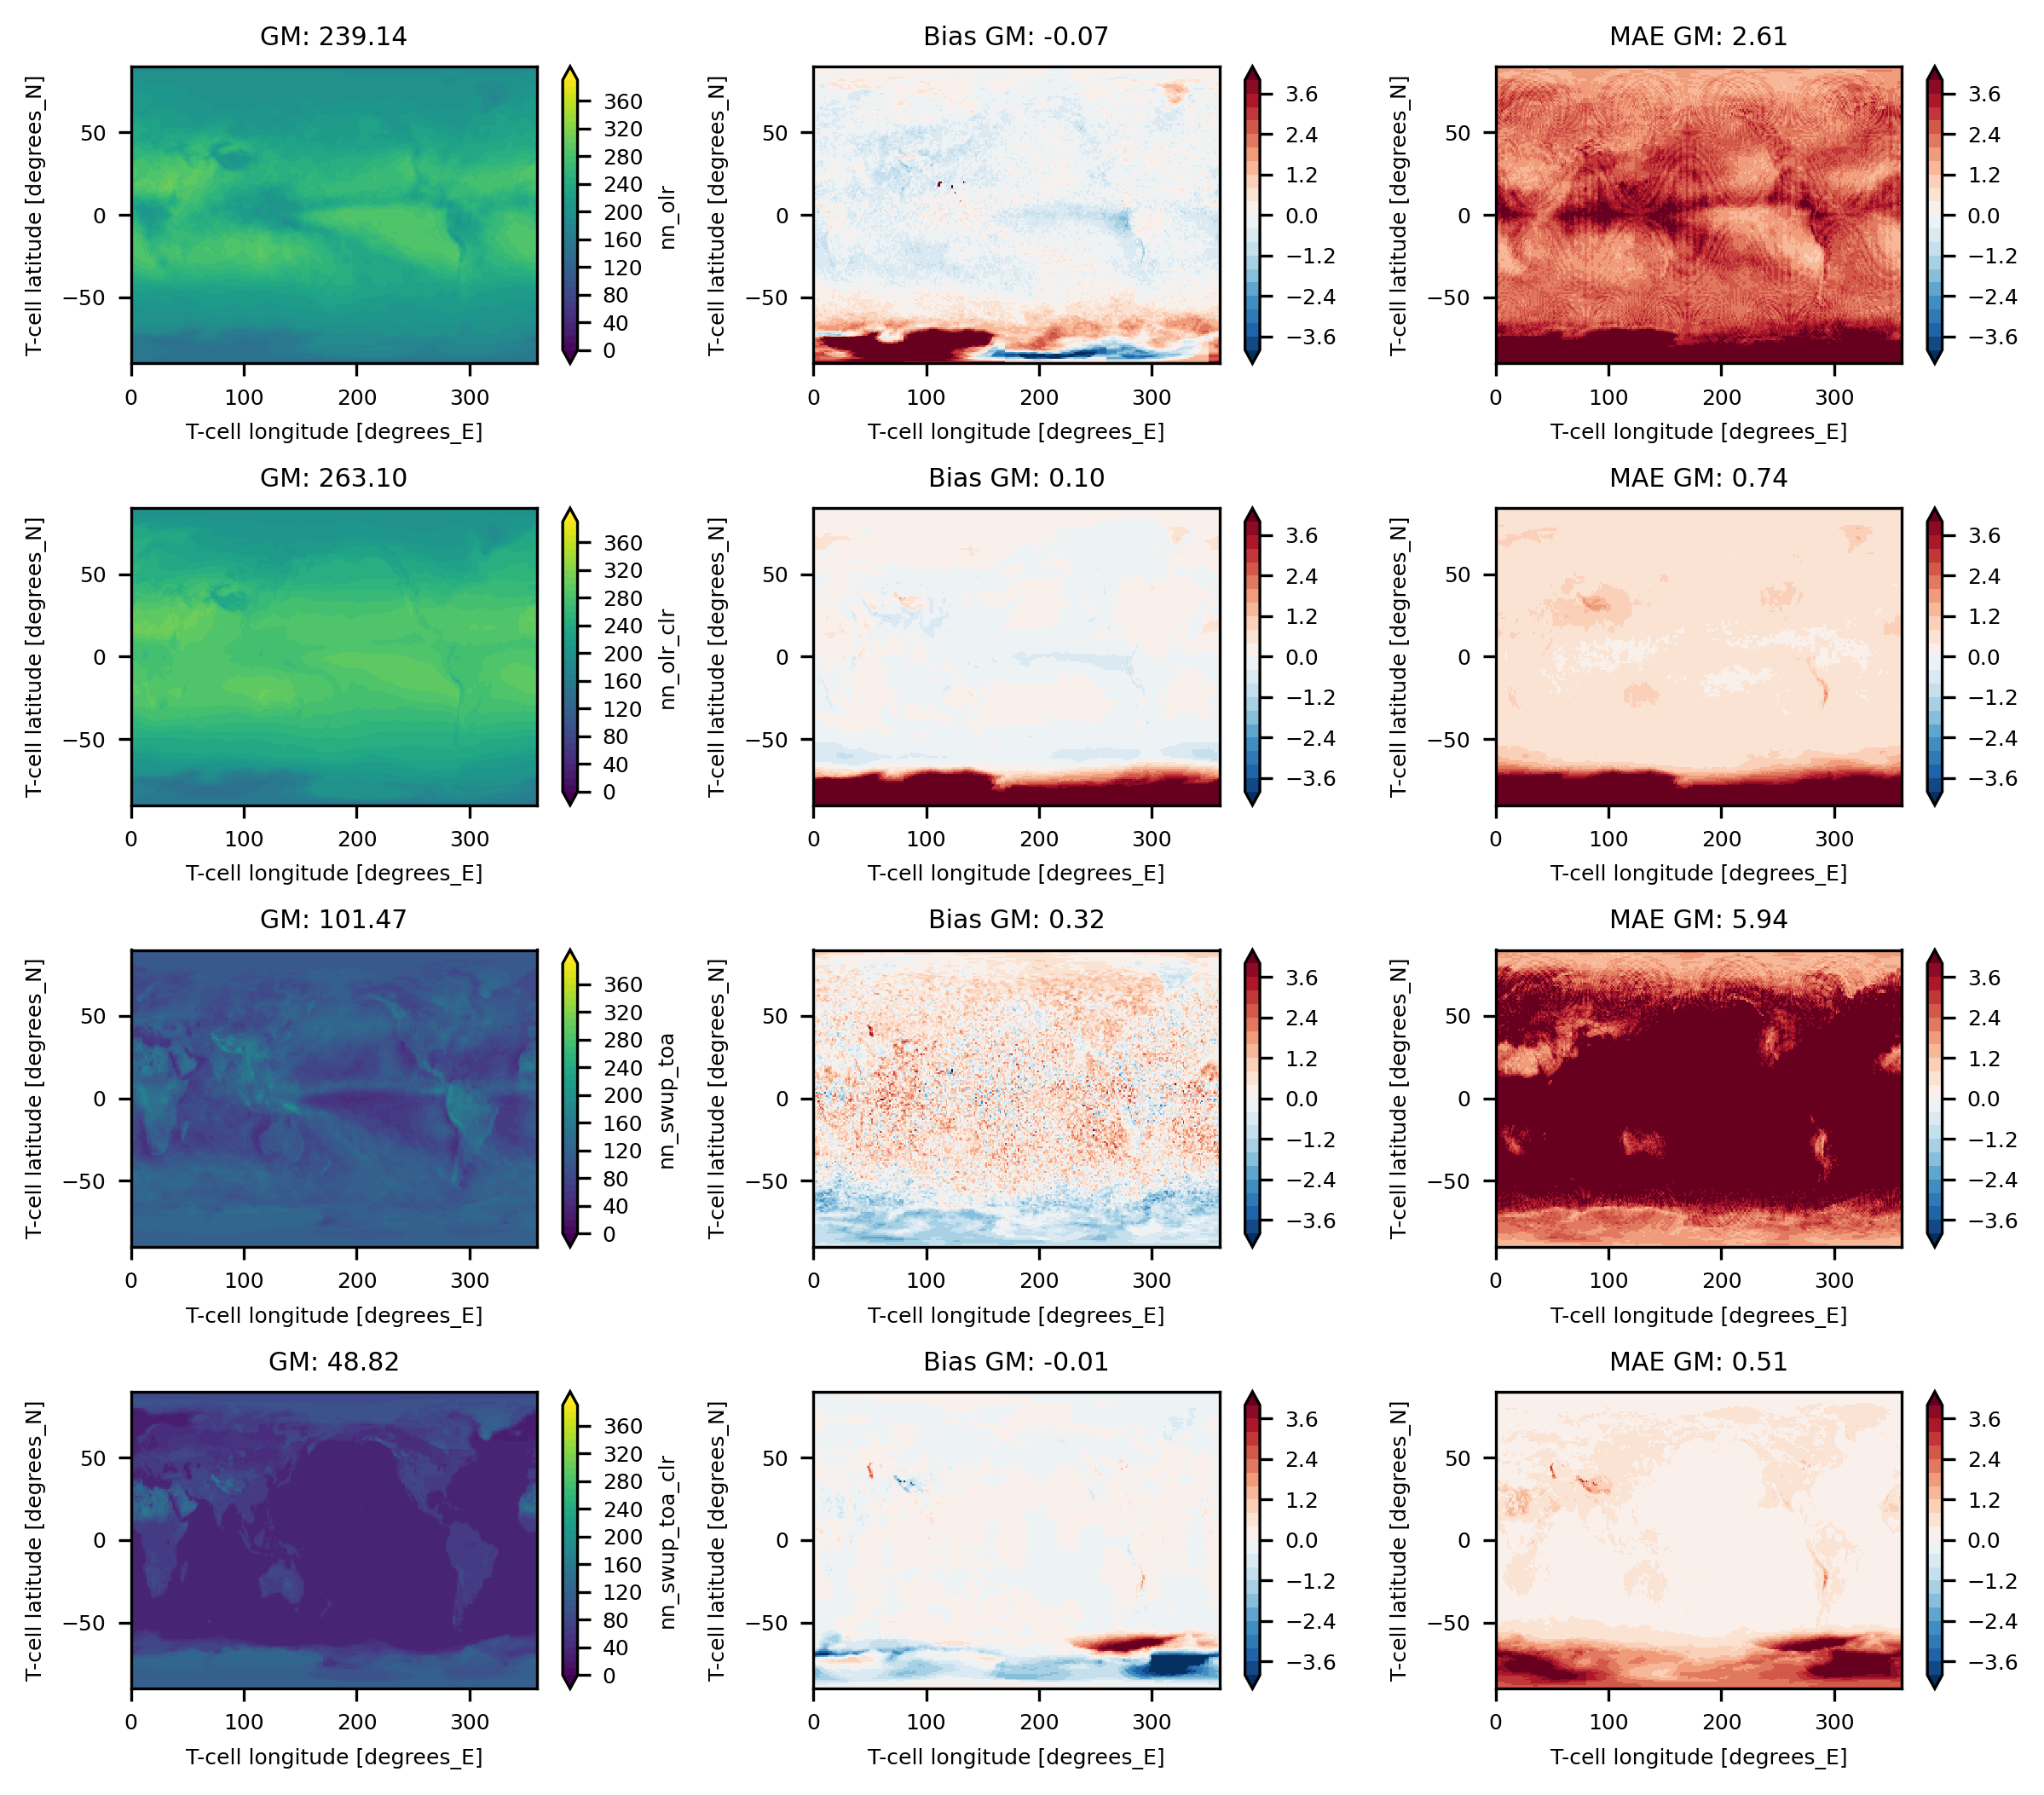

In [41]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE_base/'

ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})
month_sel = np.arange(1,13) 
day_sel = [15,18,21,24,27]
# month_sel = [1]
# day_sel = [15]
time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
ds_sel = ds.isel(time=time_sel)
var1 = ['olr','olr_clr','swup_toa','swup_toa_clr']
var2 = ['nn_olr','nn_olr_clr','nn_swup_toa','nn_swup_toa_clr']

fig, axs = plt.subplots(nrows=4,ncols=3,figsize=(8,7),dpi=300)
axs = axs.flatten()
for i in range(4):
    data1 = ds_sel[var1[i]]
    data2 = ds_sel[var2[i]]
    # clm
    level = np.arange(0,400,10)
    ax = axs[3*i]
    ds_plot = data2.mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both') 
    ax.set_title(f'GM: {global_mean_xarray(ds_plot).values:4.2f}') 
    # Bias 
    ax = axs[3*i+1]
    level = np.arange(-5,5.1,0.5)/5*4
    ds_plot = data2.mean('time') - data1.mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both', )   
    ax.set_title(f'Bias GM: {global_mean_xarray(ds_plot).values:4.2f}')
    # MAE 
    ax = axs[3*i+2] 
    ds_plot = abs (data2 - data1).mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both', )   
    ax.set_title(f'MAE GM: {global_mean_xarray(ds_plot).values:4.2f}')

fig.tight_layout()

## compare raw output

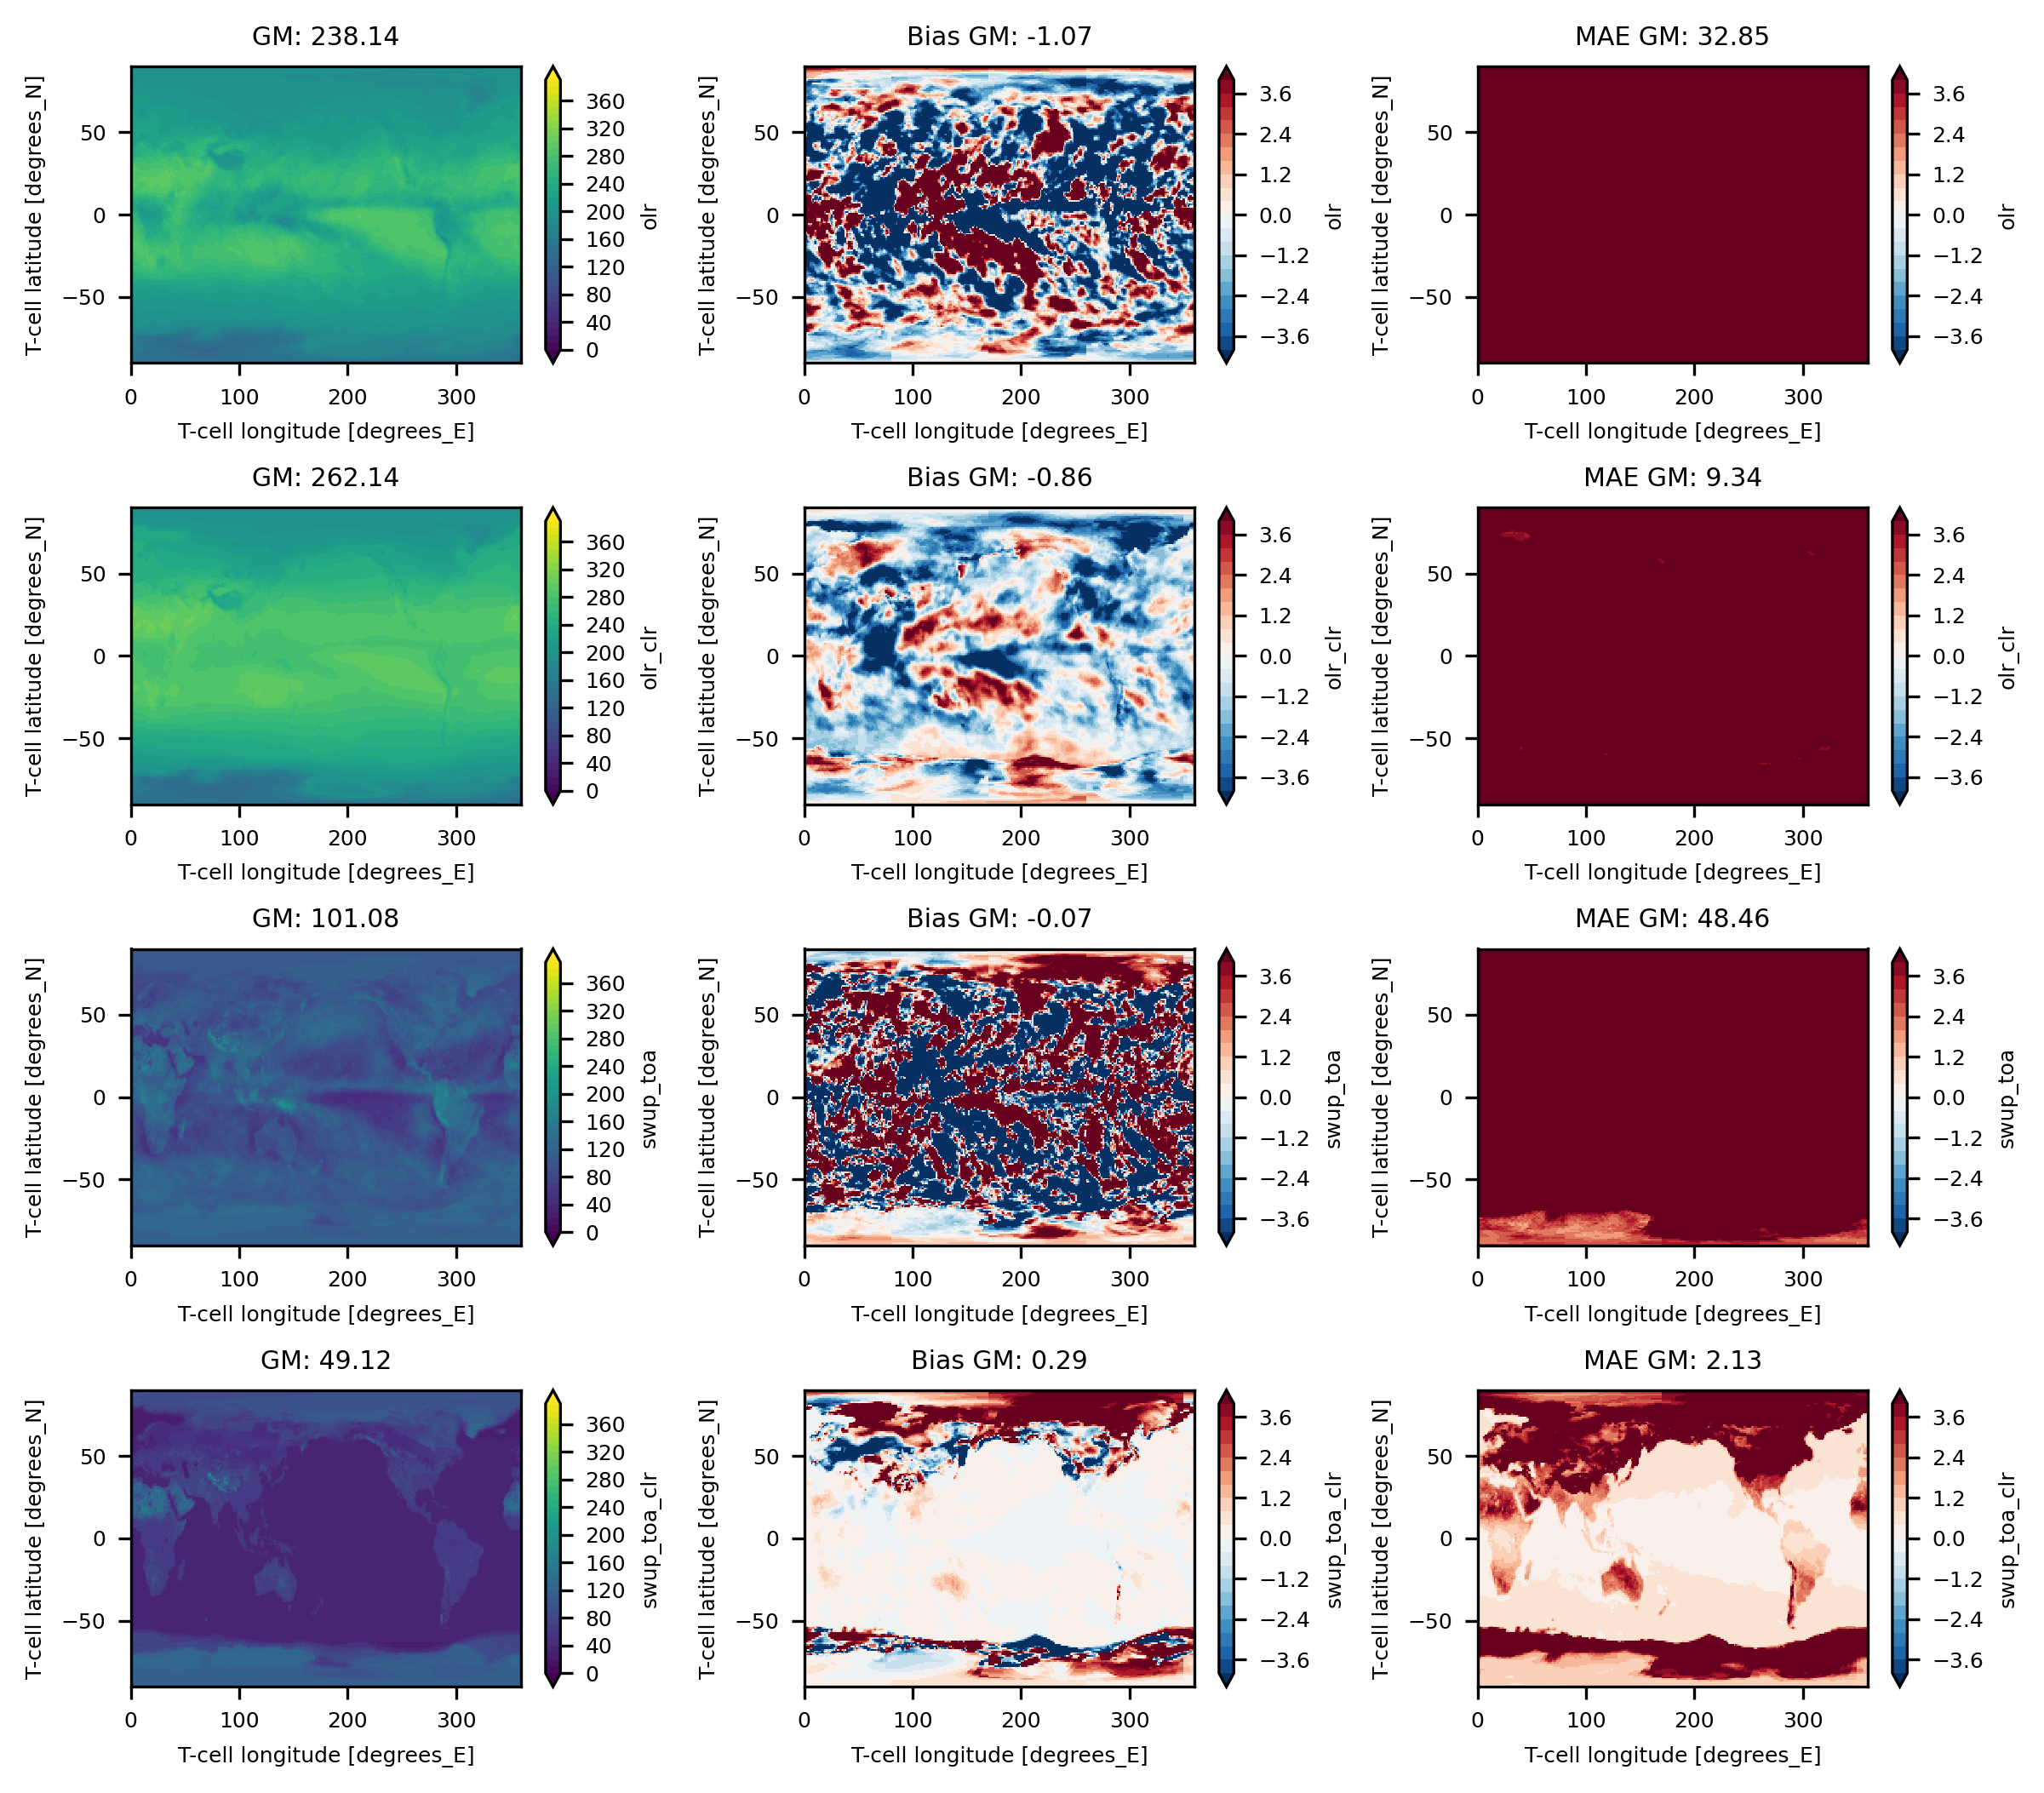

In [42]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE_base/'
ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})

file_path = '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/'
ds2 = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds2 = ds2.rename({'grid_yt':'lat','grid_xt':'lon'})
month_sel = np.arange(1,13) 
day_sel = [15,18,21,24,27]
# month_sel = [1]
# day_sel = [15]
time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
ds_sel = ds.isel(time=time_sel) 
ds_sel2 = ds2.isel(time=time_sel)
var1 = ['olr','olr_clr','swup_toa','swup_toa_clr'] 

fig, axs = plt.subplots(nrows=4,ncols=3,figsize=(8,7),dpi=300)
axs = axs.flatten()
for i in range(4):
    data1 = ds_sel[var1[i]]
    data2 = ds_sel2[var1[i]]
    # clm
    level = np.arange(0,400,10)
    ax = axs[3*i]
    ds_plot = data2.mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both') 
    ax.set_title(f'GM: {global_mean_xarray(ds_plot).values:4.2f}') 
    # Bias 
    ax = axs[3*i+1]
    level = np.arange(-5,5.1,0.5)/5*4
    ds_plot = data2.mean('time') - data1.mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both', )   
    ax.set_title(f'Bias GM: {global_mean_xarray(ds_plot).values:4.2f}')
    # MAE 
    ax = axs[3*i+2] 
    ds_plot = abs (data2 - data1).mean('time')
    ds_plot.plot(ax=ax, levels=level, extend='both', )   
    ax.set_title(f'MAE GM: {global_mean_xarray(ds_plot).values:4.2f}')

fig.tight_layout()

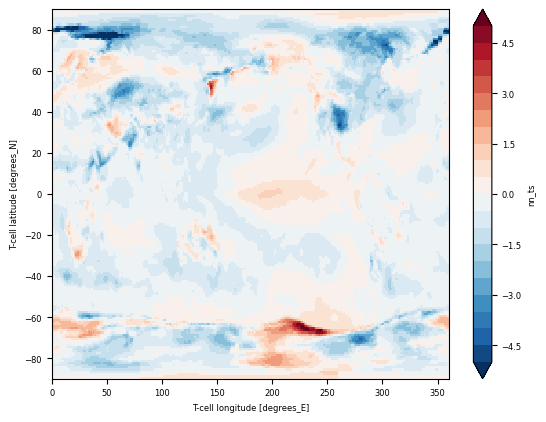

In [207]:
(ds2.nn_ts.mean('time')-ds.nn_ts.mean('time')).plot(levels=np.arange(-5,5.1,0.5))

In [4]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE_base/'
dssst = xr.open_dataset(file_path+'/INPUT/hadisst_sst.data.nc').sst.sel(lat=slice(-60,60))  
dssst_clm = xr.open_dataset('./hadisst_sst_ctl.data.nc').sst.sel(lat=slice(-60,60))   
gm1 = global_mean_xarray(dssst.groupby('time.year').mean('time'))
gm2 = global_mean_xarray(dssst_clm.mean('time'))

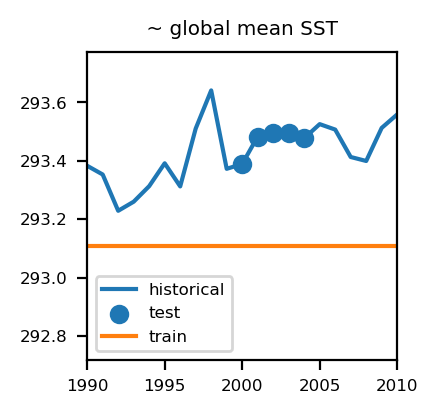

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2,2),dpi=200)

plt.plot(gm1.year,gm1, label='historical')
plt.scatter(gm1.year[131:136],gm1[131:136], label='test')
plt.plot([gm1.year[0],gm1.year[-1]],[gm2,gm2], label='train') 
plt.xlim([1990,2010])
plt.title(' ~ global mean SST ')
plt.legend(fontsize=6) 

In [6]:
nino34 = dssst.sel(time=slice('2000','2005'))\
.sel(lon = slice(190,240)).sel(lat = slice(-5,5)).mean(['lat','lon']).rolling(time=3,center=True).mean()
nino34_clm = dssst_clm.sel(time=slice('2000','2005'))\
.sel(lon = slice(190,240)).sel(lat = slice(-5,5)).mean(['lat','lon']).rolling(time=3,center=True).mean()

Text(0.5, 1.0, ' Nino3.4 region SST 3-month mean')

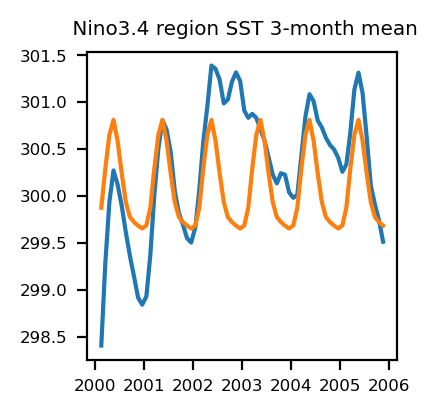

In [7]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2,2),dpi=200)

plt.plot(nino34.time,nino34) 
plt.plot(nino34_clm.time,nino34_clm) 
plt.title(' Nino3.4 region SST 3-month mean')